### 1. Imports & configuration

In [6]:
from matplotlib import pyplot as plt
from PIL import Image
import math
import cv2
%matplotlib inline
import os, os.path
import numpy as np
from sklearn.cluster import KMeans
from colormath.color_objects import sRGBColor, LabColor, HSVColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000
import csv
import pandas
from PIL import Image
from PIL import Image, ImageEnhance

picture_path = "INPUT_PICTURE_PATH"
picture_name = "INPUT_PICTURE"
dataset_path = "RESIZED_DATASET_PATH"
valid_images = [".jpg", ".jpeg", ".png"]

### 2. Colors clustering

In [7]:
class DominantColors:

    CLUSTERS = None
    COLORS = None
    LABELS = None
    CLUSTER_COUNTS = None
    INDEX_OF_MAXIMUM = None
    
    def __init__(self, image, clusters=3):
        self.CLUSTERS = clusters
        self.IMAGE = image
        self.run()
        
    def run(self):    
        #reshaping to a list of pixels
        img = self.IMAGE.reshape((self.IMAGE.shape[0] * self.IMAGE.shape[1], 3))
        
        #using k-means to cluster pixels
        kmeans = KMeans(n_clusters = self.CLUSTERS, max_iter=100)
        kmeans.fit(img)
        
        #the cluster centers are our dominant colors.
        self.COLORS = kmeans.cluster_centers_
        
        #save labels
        self.LABELS = kmeans.labels_
        _, self.CLUSTER_COUNTS = np.unique(self.LABELS[self.LABELS>=0], return_counts=True)
        
        maximum = np.max(self.CLUSTER_COUNTS)
        self.INDEX_OF_MAXIMUM = np.where(self.CLUSTER_COUNTS == maximum)
        #print("Index of the larges cluster:", self.INDEX_OF_MAXIMUM[0])
        
    def dominantColors(self):        
        return self.COLORS.astype(int)
    
    def dominantColor(self):        
        return self.COLORS[self.INDEX_OF_MAXIMUM].astype(int)
    
    def displayDominantColors(self):
        for c in self.COLORS.astype(int):
            plt.figure()
            avg_color_img = np.zeros((50,50,3), np.uint8)
            avg_color_img[:,:] = [c]
            plt.imshow(avg_color_img)
            
    def displayDominantColor(self):
        c = self.COLORS.astype(int)[self.INDEX_OF_MAXIMUM]
        plt.figure()
        avg_color_img = np.zeros((50,50,3), np.uint8)
        avg_color_img[:,:] = [c]
        plt.imshow(avg_color_img)
        plt.show()

### 3. Util functions

In [8]:
# load single image
def load_image(name, path=dataset_path):
    im = Image.open(path + "/" + name)
    return np.array(im)

def load_and_resize_image(name, path=dataset_path, size=(50,50)):
    img = load_image(name, path)
    return resize_image(img, size)

# resize image to fixed size
def resize_image(img, size=(50, 50)):
    resized_img = cv2.resize(img, size)        
    return resized_img

# returns the list of images and labels
def load_images_labels(path):
    imgs = []
    labels = []
    for f in os.listdir(path):
        ext = os.path.splitext(f)[1]
        if ext.lower() not in valid_images:
            continue
        labels.append(f)
    return labels

# divides image in k x k pixels areas, returns image segements and array of mean brightnesses
def segment_image(img, k):
    segments = [img[x:x+k,y:y+k] for x in range(0,img.shape[0],k) for y in range(0,img.shape[1],k)]
    brightness = []
    for s in segments:
        hsv = cv2.cvtColor(s, cv2.COLOR_RGB2HSV)
        brightness.append(int(hsv[:,:,2].mean()))
    return segments, brightness


# restores original image from tiles
def restore_image(tiles):
    dim = int(math.sqrt(len(tiles)))
    height = int(sum(tile.shape[0] for tile in tiles)/dim)
    width = int(sum(tile.shape[1] for tile in tiles)/dim)
    output = np.zeros((height, width, 3), np.uint8)
    i=0
    j=0
    k=0
    for tile in tiles:
        
        h,w,d = tile.shape        
        output[i:i+h, j:j+w] = tile
        j += w
        k += 1
        if k == dim:
            k = 0
            i += h
            j=0

    return output

def restore_image_from_labels(similar_tiles, original_b):
    m_list = []
    
    for idx, l in enumerate(similar_tiles):
        img = load_image(str(l['label'].values[0]))
        img = Image.fromarray(img)
        enhancer = ImageEnhance.Brightness(img)
        enhancer2 = ImageEnhance.Color(img)
        if original_b[idx] > int(l['b'].values[0]):
            img = enhancer.enhance(0.75*original_b[idx]/int(l['b'].values[0]))
            img = enhancer2.enhance(0.95)
        else:
            img = enhancer.enhance(1.1*original_b[idx]/int(l['b'].values[0]))
        img = np.array(img)
        m_list.append(img)
    return restore_image(m_list)

# display grid of tiles
def show_tiles(tiles):
    fig = plt.figure()
    n = len(tiles)
    nsqr = math.sqrt(n)
    for i in range(n):    
            #print(i, tiles[i].shape)
            plt.subplot(nsqr, nsqr, i+1)
            plt.imshow(tiles[i])
            plt.xticks(())
            plt.yticks(())
    
def image_similarity(col1, col2):
    
    color1_rgb = sRGBColor(col1[0], col1[1], col1[2]);
    color2_rgb = sRGBColor(col2[0], col2[1], col2[2]);

    # Convert from RGB to Lab Color Space
    color1_lab = convert_color(color1_rgb, LabColor);

    # Convert from RGB to Lab Color Space
    color2_lab = convert_color(color2_rgb, LabColor);

    # Find the color difference
    # delta_e_cie2000, delta_e_cie1976, delta_e_cie1994, delta_e_cmc
    delta_e = delta_e_cie2000(color1_lab, color2_lab);
    return delta_e
        
                
def load_dominant_colors(path):
    dcFrame = pandas.read_csv(path)
    return dcFrame

def adjacent_images(segments, similar_tiles, k=1): 
    adjacent_imgs = []
    dim = int(math.sqrt(len(segments)))
    l = int(len(similar_tiles)) #l je indeks current_segmenta u segments
    
    if k>dim:
        print("Window too big!")
        return adjacent_imgs
    
    i_current = int(l//dim)
    j_current = int(l%dim)
    
    for i in range (max(0,i_current-k), i_current): #ne gledam još redak u kojem je current tile
        for j in range (j_current-k, j_current+k+1):
            adjacent_imgs.append(similar_tiles[i*dim+j]['label'].values[0])
            
    for j in range (max(0,j_current-k), j_current):
        adjacent_imgs.append(similar_tiles[i_current*dim+j]['label'].values[0])
                
    return adjacent_imgs

def find_similar_tile_index(dcolor, dcFrame, adjacent_imgs):
    minDiff = float('inf')
    minIndex = -1
    
    if len(adjacent_imgs)>0:
        member = dcFrame['label'].isin(adjacent_imgs)
        dfFrame = dcFrame[~member]
    else:
        dfFrame = dcFrame
        
    for index, row in dfFrame.iterrows():
        sim = image_similarity(dcolor, (int(row['r']), int(row['g']), int(row['b'])))
        if (sim < minDiff):
            minDiff = sim
            minIndex = index
            minLabel = row['label']
            
    return dfFrame[dfFrame['label']==minLabel]
    
def construct_mosaic_matrix(segments, dc, pic_k, n_neighbours=1):
    similar_tiles = []      
    for idx, segment in enumerate(segments):
        if (idx%400 == 0):
            print(idx)
        dc = DominantColors(segment, pic_k)
        dcolor = dc.dominantColor()[0]
        adjacent_imgs = adjacent_images(segments, similar_tiles, n_neighbours)
        similar_tile = find_similar_tile_index(dcolor, dcFrame, adjacent_imgs)
        similar_tiles.append(similar_tile)
    return similar_tiles


def extract_dominant_colors(labels, k=2, to_csv=False):
    dom_colors = []
    brightness = []
    for i,label in enumerate(labels):
        im = load_image(label)
        dc = DominantColors(im, k) 
        dom_colors.append(dc.dominantColor()[0])
        hsv = cv2.cvtColor(im, cv2.COLOR_RGB2HSV)
        brightness.append(hsv[:,:,2].mean())
    if to_csv == True:   
        with open('pigs.csv', mode='w') as pigs_file:
            writer = csv.writer(pigs_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            writer.writerow(["r","g","b","light","label"])
            for c,l,b in zip(dom_colors, labels, brightness):
                writer.writerow([str(c[0]),str(c[1]),str(c[2]),str(int(b)),l])
                

### 4. extract dominant colors

In [9]:
labels = load_images_labels(dataset_path)
extract_dominant_colors(labels,1,True)
dominant_colors = load_dominant_colors('colors.csv')
dominant_colors.head()

,r,g,b,light,label
0,138,106,85,138,1.jpg
1,128,103,81,128,10.jpg
2,158,113,95,158,100.jpg
3,123,118,110,125,101.jpg
4,121,116,118,131,102.jpg


### 5. Testing

started
(2000, 2000, 3)
0
400
800
1200
1600
2000
2400
2800
3200
3600
4000
4400
4800
5200
5600
6000
(8000, 8000, 3)


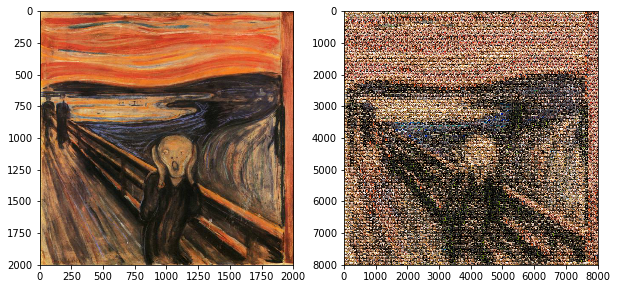

In [10]:
labels = load_images_labels(dataset_path)
orig_pic = load_and_resize_image(picture_name, picture_path, size=(2000, 2000))
print(orig_pic.shape)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(orig_pic)
pic_segments, brightness_original = segment_image(orig_pic, 25)

dcFrame = load_dominant_colors('colors.csv')
similar_tiles = construct_mosaic_matrix(pic_segments, dcFrame, pic_k=1, n_neighbours=1)
result = restore_image_from_labels(similar_tiles, brightness_original)
plt.subplot(1,2,2)
plt.imshow(result)
im = Image.fromarray(result)
im.save("result.jpg", "JPEG", quality=90)